In [35]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time as time

In [36]:
def nft(y, N):
    c = np.zeros(N, dtype=np.complex)
    for k in range(N):
        for n in range(N):
            c[k] += (y[n]*np.e**(-1j*2*np.pi*k*n/N))
    return c

In [37]:
def inv_nft(y, N):
    c = np.zeros(N, dtype=np.complex)
    for k in range(N):
        for n in range(N):
            c[k] += (y[n]*np.e**(1j*2*np.pi*k*n/N))
    return c/N

In [42]:
def fft(y, N): #N needs to be a power of 2 for this to work
    if int(N)==1:
        return y
    else:
        even = fft(y[0:int(N):2], int(N/2))
        odd = fft(y[1:int(N):2], int(N/2))
        first_half=[]
        second_half=[]
        for k in range(int(N/2)):
            first_half.append( even[k] + np.e**(-1j*2*np.pi*k/int(N))*odd[k] )   
            second_half.append( even[k] - np.e**(-1j*2*np.pi*k/int(N))*odd[k] )
    return np.array(first_half + second_half)

In [43]:
def inv_fft(y, N):
    if int(N)==1:
        return y
    else:
        even = inv_fft(y[0:int(N):2], int(N/2))
        odd = inv_fft(y[1:int(N):2], int(N/2))
        first_half=[]
        second_half=[]
        for k in range(int(N/2)):
            first_half.append( even[k] + np.e**(1j*2*np.pi*k/int(N))*odd[k] )   
            second_half.append( even[k] - np.e**(1j*2*np.pi*k/int(N))*odd[k] )
            
    return np.array(first_half + second_half)

C:\Users\addya\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log2
C:\Users\addya\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log2
C:\Users\addya\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log2


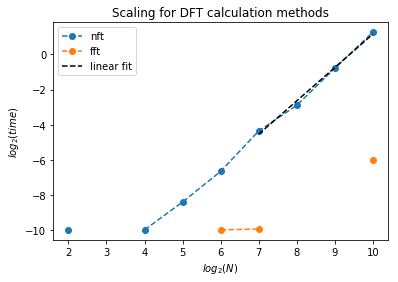

In [45]:
#######################################################
####### TESTING THE METHODS ON A RANDOM SAMPLE  #######
#######################################################

N = []
for i in range(11): 
    N.append(2**i)
    
ts_nft=np.zeros(len(N))
ts_fft=np.zeros(len(N))

for i in range(len(N)):
    
    a = np.random.rand(N[i])
    
    # Updating time for nft
    t1=time.time() 
    f_a = nft(a, len(a))
    t2=time.time()
    ts_nft[i] = t2-t1
    
    #Updating time for fft
    t1=time.time() 
    f_a = fft(a, len(a))
    t2=time.time()
    ts_fft[i] = t2-t1


#Graph to show scaling for different methods
fig1 = plt.figure()
m_nft, b_nft = np.polyfit(np.log2(N[7:]),np.log2(ts_nft[7:]),1)
m_fft, b_fft = np.polyfit(np.log2(N[7:]),np.log2(ts_fft[7:]),1)
plt.plot(np.log2(N),np.log2(ts_nft),'o--',label='nft')
plt.plot(np.log2(N),np.log2(ts_fft),'o--',label='fft')

plt.plot(np.log2(N[7:]), np.log2(N[7:])*m_nft + b_nft, 'k--', label = 'linear fit')
plt.plot(np.log2(N[7:]), np.log2(N[7:])*m_fft + b_fft, 'k--')
plt.legend()
plt.title('Scaling for DFT calculation methods')
plt.xlabel('$log_2(N)$')
plt.ylabel('$log_2(time)$')
plt.show()

In [46]:
m_nft

1.8941117550682158

In [5]:
def loadligodata(filename):
    f = h5py.File(filename, "r")
    strain = f['strain/Strain'][...]
    t0 = f['strain/Strain'].attrs['Xstart']
    dt = f['strain/Strain'].attrs['Xspacing']
    t = t0 + dt * np.arange(strain.shape[0])
    f.close()
    return t,strain

In [6]:
### A filter that is like an inverted sigmoid ###
def step_filter(f, f0, n):
    return (1/(1+(f/f0)**(2*n)))


In [7]:
### A filter that is like a sigmoid ###
def step_filter_flipped(f, f0, n):
    a = np.zeros(len(f))
    for i in range(len(f)):
        if f[i] == 0:
            a[i] = 0
        else:
            a[i] = (1/(1+(f0/f[i])**(2*n)))
    return a 


In [8]:
### A bandpass filter combining two step filters ###
def bandpass_filter(f,f1,f2,n):
    return step_filter(f, f2, n) * step_filter_flipped(f, f1, n)

In [9]:
### Gaussian filter for the peaks ###
def gauss_filter(f,f0,sigma):
    return 1 - np.e**(-(f-f0)**2 /(2*sigma**2))  

In [13]:
t_h,strain_h = loadligodata('H-H1_LOSC_4_V2-1126259446-32.hdf5') #Data from Hanford 
t_l,strain_l = loadligodata('L-L1_LOSC_4_V2-1126259446-32.hdf5') #Data from Livingston 

Text(0, 0.5, 'strain $h(t)$')

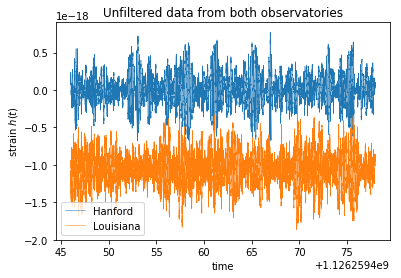

In [14]:
#Plotting unfiltered strain signal
fig2 = plt.figure()
plt.plot(t_h,strain_h, linewidth ='0.5' ,label='Hanford')
plt.plot(t_l,strain_l, linewidth ='0.5' ,label='Louisiana')
plt.legend()
plt.title('Unfiltered data from both observatories')
plt.xlabel('time')
plt.ylabel('strain $h(t)$')

In [15]:
### Obtaining the Periodogram ###

hk_h = fft(strain_h, len(strain_h)) #Hanford fft of strain
P_h = (hk_h*np.conjugate(hk_h)).real #Unfiltered periodogram Hanford

hk_l = fft(strain_l, len(strain_l)) #Louisiana fft of strain
P_l = (hk_l*np.conjugate(hk_l)).real #Unfiltered periodogram Louisiana


Text(0, 0.5, 'Log of Periodogram ($log_{10}(P_{hh})$)')

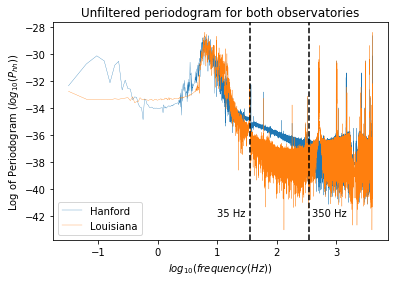

In [16]:
#Min freq = 0, max freq = sampling rate = 4096 Hz
f = np.linspace(0,4096,len(hk_h))

## Plotting the unfiltered periodogram
fig3=plt.figure()
plt.plot( np.log10(f[1:]) , np.log10(P_h[1:]), linewidth ='0.3' ,label='Hanford')
plt.plot( np.log10(f[1:]) , np.log10(P_l[1:]), linewidth ='0.3' ,label='Louisiana')
plt.axvline(x=np.log10(35), color='k', linestyle='--')
plt.axvline(x=np.log10(350), color='k', linestyle='--')
plt.text(np.log10(35)-0.55,-42,'35 Hz')
plt.text(np.log10(350)+0.05,-42,'350 Hz')
plt.legend()
plt.title('Unfiltered periodogram for both observatories')
plt.xlabel('$log_{10}(frequency(Hz))$')
plt.ylabel('Log of Periodogram ($log_{10}(P_{hh})$)')

In [47]:
### Band Filter 35 Hz to 350 Hz ###
hk_h_band = hk_h * bandpass_filter(f,35,350,8) #Fourier coefficients after band filtering Hanford
hk_l_band = hk_l * bandpass_filter(f,35,350,8) #Fourier coefficients after band filtering Louisiana
P_h_band = (hk_h_band*np.conjugate(hk_h_band)).real #Periodogram after band filtering Hanford
P_l_band = (hk_l_band*np.conjugate(hk_l_band)).real #Periodogram after band filtering Louisiana

strain_h_band =inv_fft(hk_h_band, len(hk_h_band)).real/len(hk_h_band) #Strain after band filtering Hanford
strain_l_band =inv_fft(hk_l_band, len(hk_l_band)).real/len(hk_l_band) #Strain after band filtering Louisiana

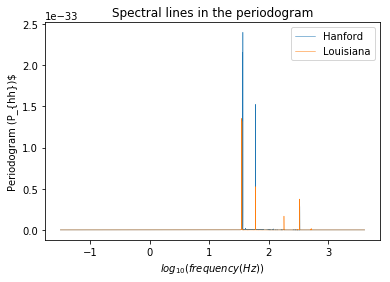

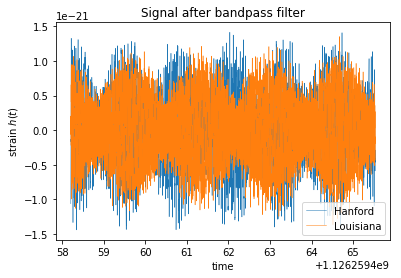

In [48]:
fig4=plt.figure()
plt.plot( np.log10(f[1:]) , P_h_band[1:], linewidth ='0.5' ,label='Hanford')
plt.plot( np.log10(f[1:]) , P_l_band[1:], linewidth ='0.5' ,label='Louisiana')
plt.legend()
plt.title('Spectral lines in the periodogram')
plt.xlabel('$log_{10}(frequency(Hz))$')
plt.ylabel('Periodogram (P_{hh})$')
#plt.savefig('bandperiodogram.eps', format='eps', dpi=1000)

fig5=plt.figure()
plt.plot(t_h[50000:80000],strain_h_band[50000:80000], linewidth ='0.5',label='Hanford')
plt.plot(t_l[50000:80000],strain_l_band[50000:80000], linewidth ='0.5',label='Louisiana')
plt.title('Signal after bandpass filter')
plt.xlabel("time")
plt.ylabel("strain $h(t)$")
plt.legend()
#plt.savefig('bandsignal.eps', format='eps', dpi=1000)

Text(0, 0.5, 'strain $h(t)$')

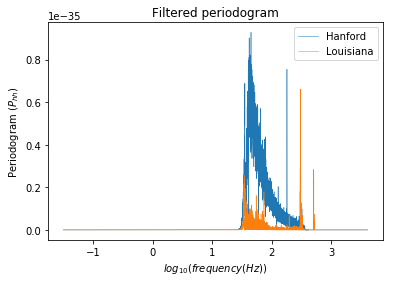

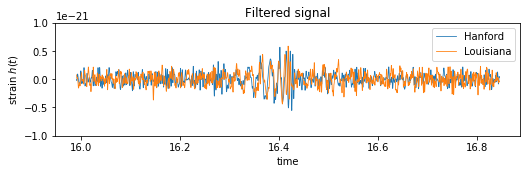

In [25]:
## DETECTING PEAKS with the band filtered periodogram ###

hk_h_filt = hk_h_band
hk_l_filt = hk_l_band
for i in range(len(P_h_band)):
    if P_h_band[i]>1e-35:
        hk_h_filt = hk_h_filt * gauss_filter(f,f[i],0.1)
    if P_l_band[i]>1e-35:
        hk_l_filt = hk_l_filt * gauss_filter(f,f[i],0.1)

### Periodogram after removing peaks ###
P_h_filt = (hk_h_filt*np.conjugate(hk_h_filt)).real #Periodogram after all filtering Hanford
P_l_filt = (hk_l_filt*np.conjugate(hk_l_filt)).real #Periodogram after all filtering Louisiana

strain_h_filt = inv_fft(hk_h_filt,len(hk_h_filt)).real/len(hk_h_filt) #Strain after all filtering Hanford
strain_l_filt = inv_fft(hk_l_filt,len(hk_l_filt)).real/len(hk_l_filt) #Strain after all filtering Louisiana

fig6= plt.figure()
plt.plot( np.log10(f[1:]) , P_h_filt[1:], linewidth ='0.5' ,label='Hanford')
plt.plot( np.log10(f[1:]) , P_l_filt[1:], linewidth ='0.5' ,label='Louisiana')
#plt.axvline(x=np.log10(35), color='k', linestyle='--')
#plt.axvline(x=np.log10(350), color='k', linestyle='--')
#plt.text(np.log10(35)-0.55,-100,'35 Hz')
#plt.text(np.log10(350)+0.05,-100,'350 Hz')
plt.title('Filtered periodogram')
plt.xlabel('$log_{10}(frequency(Hz))$')
plt.ylabel('Periodogram ($P_{hh}$)')
plt.legend()


t = t_h - t_h[0] #Time axis shifted TO:  0s to 32s

fig7=plt.figure(figsize=(10/1.2,2.5/1.2))
plt.plot(t[65500:69000],strain_h_filt[65500:69000], linewidth ='0.8',label='Hanford')
plt.plot(t[65500:69000],strain_l_filt[65500:69000], linewidth ='0.8',label='Louisiana')
plt.legend()
plt.ylim(-1e-21,1e-21)
plt.title('Filtered signal')
plt.xlabel('time')
plt.ylabel('strain $h(t)$')